In [1]:
%run forward_simulation.ipynb

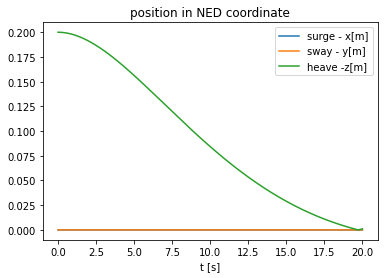

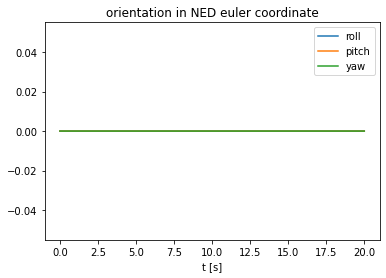

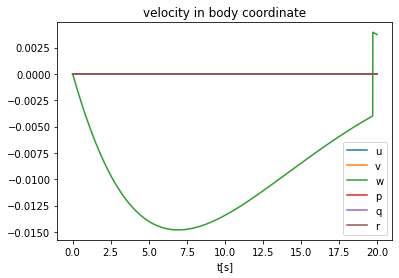

In [2]:
# SIMULATING vehicle from below water surface
import matplotlib.pyplot as plt
sim = Fsim.mapaccum(blue.N)
x0 = np.array([0.0, 0.0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z r p y u v w p q r
u0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
vc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
f_ext_0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
res = sim(x0, u0, blue.sim_params, blue.dt_s, f_ext_0)
res.T
t = np.linspace(0, blue.T, blue.N+1)


# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((12,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((12,1)), res.toarray()), axis=1)[3:6,:].T)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((12,1)), res.toarray()), axis=1)[6::,:].T)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("velocity in body coordinate")
plt.show()